In [51]:
import os
import requests
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image

In [52]:
import torch
from torch import nn
from torchvision import transforms
from torchvision.io import read_image
from torch.utils.data import Dataset, DataLoader

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [3]:
# r = requests.Session()
# URL = "https://passport.bilibili.com/web/captcha/img"
# for i in range(4096):
#   img_bytes = r.get(URL).content
#   with open(f'real/{i}.jpg', 'wb') as f:
#     f.write(img_bytes)

# im = Image.open("real/0.jpg")
# im = im.convert('1')
# plt.imshow(im, cmap='gray')
# WIDTH, HEIGHT = im.size
# imarr = np.array(im)
# print(im.size, im.mode, imarr.shape)
# im.close()
# plt.show()

In [53]:
REAL_DIR = 'real/'
WIDTH = 200
HEIGHT = 50


BATCH_SIZE = 128
LOG_INTERVAL = 10

In [54]:
trans_real = transforms.Compose([
  transforms.Grayscale(),
])

class RealDataset(Dataset):
    def __init__(self, root, transform=None):
        self.root = root
        self.image_paths = os.listdir(root)
        self.transform = transform
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        x = read_image(os.path.join(self.root, image_path)).type(torch.FloatTensor)
        if self.transform is not None:
            x = self.transform(x)
        return x
    
    def __len__(self):
        return len(self.image_paths)

real_ds = RealDataset(root=REAL_DIR, transform=trans_real)
real_dl = DataLoader(real_ds, batch_size=BATCH_SIZE)

In [55]:
import random
from typing import Tuple
from string import ascii_uppercase, digits
from wheezy.captcha import image as wheezy_captcha
from PIL import ImageFont, ImageOps


text_drawings = [
            wheezy_captcha.warp(dx_factor=0.4, dy_factor=0.1),
            wheezy_captcha.rotate(angle=1),
            wheezy_captcha.offset(),
        ]
capfn = wheezy_captcha.captcha(
        drawings=[
            wheezy_captcha.background(color="#000000"),
            wheezy_captcha.text(fonts=['arial-extra.otf'], color="#FFFFFF", font_sizes=[50], drawings=text_drawings, squeeze_factor=1),
            wheezy_captcha.curve(color="#FFFFFF", number=12),
            wheezy_captcha.smooth(),
        ],
        width=WIDTH,
        height=HEIGHT,
    )

def fakecap(s='',leng=5, mode='RGB') -> Tuple[Image.Image, str]:
    if not s:
        chset = ascii_uppercase + digits
        s = ''.join(random.choices(chset, k=leng))
    im = ImageOps.invert(capfn(s))
    if mode == 'gray':
        im = im.convert('L')
    return im, s

In [56]:
import one_hot_encoding as ohe
trans_fake = transforms.Compose([
  transforms.Grayscale(),
  transforms.ToTensor()
])

class FakeDataset(Dataset):
    def __init__(self, size=BATCH_SIZE, transform=None):
        self.size = size
        self.transform = transform
        
    def __getitem__(self, index):
        x, label = fakecap()
        if self.transform is not None:
            x = self.transform(x)
        label = ohe.encode(label)
        return x, label
    
    def __len__(self):
        return self.size

fake_ds = FakeDataset(transform=trans_fake)
fake_dl = DataLoader(fake_ds, batch_size=BATCH_SIZE)

torch.Size([128, 1, 50, 200])


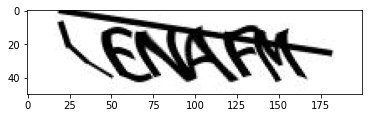

In [57]:
X = next(iter(real_dl))
print(X.shape)
img = X[0].squeeze()
plt.imshow(img, cmap='gray')

torch.Size([128, 1, 50, 200]) 1PX4E


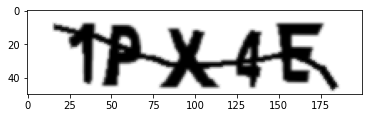

In [8]:
for X, labels in fake_dl:
  print(X.shape, labels[0])
  img = X[0].squeeze()
  plt.imshow(img, cmap='gray')
  break

## Network Structure

In [9]:
class ResnetBlock(nn.Module):
    def __init__(self, inplanes, planes):
        super(ResnetBlock, self).__init__()
        self.relu = nn.ReLU(inplace=True)
        self.convs = nn.Sequential(
          nn.Conv2d(inplanes, planes, kernel_size=3, padding='same'), 
          self.relu,
          nn.Conv2d(inplanes, planes, kernel_size=3, padding='same'),
        )

    def forward(self, x):
        out = self.convs(x)
        out = torch.add(x, out)
        out = self.relu(out)
        return out

class Refiner(nn.Module):
    def __init__(self, in_features, nb_features=64, block_num=4):
        super(Refiner, self).__init__()
        self.block_num = block_num
        blocks = [ResnetBlock(nb_features, nb_features) for _ in range(block_num)]
        self.conv1 = nn.Sequential(
          nn.Conv2d(in_features, nb_features, 3, padding='same'),
          nn.ReLU(inplace=True)
        )
        self.resnet_block = nn.Sequential(*blocks)
        self.conv2 = nn.Sequential(
          nn.Conv2d(nb_features, in_features, 3, padding='same'),
          nn.Tanh()
        )

    def forward(self, x):
      out = self.conv1(x)
      out = self.resnet_block(out)
      out = self.conv2(out)
      return out

class Discriminator(nn.Module):
    def __init__(self, in_features):
        super(Discriminator, self).__init__()

        self.convs = nn.Sequential(
            nn.Conv2d(in_features, 96, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(96),

            nn.Conv2d(96, 64, 3, 2, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(64),

            nn.AvgPool2d(3, 1, padding=1),

            nn.Conv2d(64, 32, 3, 1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 32, 3, 1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 32, 1, 1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(32),

            nn.Conv2d(32, 2, 1, 1, padding=1),
            nn.LeakyReLU(),
        )

    def forward(self, x):
        out = self.convs(x)
        out = out.reshape((-1,2))
        return out

In [10]:
from itertools import groupby
from skimage.util import montage

def plot_batch(image_batch, figure_path, label_batch=None):
    
    all_groups = {label: montage(np.stack([img[0,:,:] for img, lab in img_lab_list],0)) 
                  for label, img_lab_list in groupby(zip(image_batch, label_batch), lambda x: x[1])}
    fig, c_axs = plt.subplots(1,len(all_groups), figsize=(len(all_groups)*4, 8), dpi = 600)
    for c_ax, (c_label, c_mtg) in zip(c_axs, all_groups.items()):
        c_ax.imshow(c_mtg, cmap='bone')
        c_ax.set_title(c_label)
        c_ax.axis('off')
    # fig.savefig(os.path.join(figure_path))
    plt.show()
    plt.close()

In [11]:
R = Refiner(1).to(device)
opt_R = torch.optim.Adam(R.parameters())
self_regularization_loss = nn.L1Loss(reduction='sum')

D = Discriminator(1).to(device)
opt_D = torch.optim.SGD(D.parameters(), lr=0.001)
local_adversarial_loss = nn.CrossEntropyLoss(reduction='mean')

In [13]:
gen_loss = 0
epoch = 100
nplot = 16

for i in range(epoch):
  fake_batch = next(iter(fake_dl))[0].to(device)
  refined_batch = R(fake_batch)
  R.train()
  r_loss = self_regularization_loss(refined_batch, fake_batch)
  opt_R.zero_grad()
  r_loss.backward()
  opt_R.step()
  gen_loss += r_loss.item()

  if not i % LOG_INTERVAL:
    print('pre-training generator step {}/{}: loss = {:.10f}'.format(i, epoch, gen_loss / LOG_INTERVAL))
    gen_loss = 0
    if not i % (10 * LOG_INTERVAL):
      with torch.no_grad():
        syn_imgs = next(iter(fake_dl))[0][:nplot].to(device)
        ref_imgs = R(syn_imgs)
        plot_batch(np.concatenate((syn_imgs.cpu(), ref_imgs.cpu())), None, 
        label_batch=['Synthetic'] * nplot + ['Refined'] * nplot)
      
R_PATH = 'model/R.pth'
torch.save(R.state_dict(), R_PATH)

In [24]:
R_PATH = "model/R_{}.pth".format(100)
R = Refiner(1).to(device)
R.load_state_dict(torch.load(R_PATH))
real_batch = next(iter(real_dl))
fake_batch = next(iter(fake_dl))[0]
assert fake_batch.shape == real_batch.shape, "{} {}".format(fake_batch.shape, real_batch.shape)
print(real_batch.type(), fake_batch.type())

torch.FloatTensor torch.FloatTensor


In [15]:
epoch = 100

D.train()
R.eval()
for i in range(epoch):
  real_batch = next(iter(real_dl)).to(device)
  fake_batch = next(iter(fake_dl))[0].to(device)
  assert real_batch.shape == fake_batch.shape

  real_pred = D(real_batch).view(-1,2).to(device)
  real_y = torch.zeros(real_pred.shape[0]).type(torch.LongTensor).to(device)
  d_loss_real = local_adversarial_loss(real_pred, real_y)
  real_out = nn.functional.softmax(real_pred).max(1)[1]
  acc_real = (real_out == real_y).float().mean()

  ref_batch = R(fake_batch).to(device)
  ref_pred = D(ref_batch).view(-1,2).to(device)
  ref_y = torch.ones(real_pred.shape[0]).type(torch.LongTensor).to(device)
  d_loss_ref = local_adversarial_loss(ref_pred, ref_y)
  ref_out = nn.functional.softmax(ref_pred).max(1)[1]
  acc_ref = (ref_out == ref_y).float().mean()

  d_loss = d_loss_real + d_loss_ref
  opt_D.zero_grad()
  d_loss.backward()
  opt_D.step()

  if not i % LOG_INTERVAL:
    print(f"Discriminator step {i}/{epoch}: real_acc: {acc_real}, ref_acc: {acc_ref}")

D_PATH = 'model/D.pth'
torch.save(D.state_dict(), D_PATH)

/tmp/ipykernel_7333/2549440320.py:13: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  real_out = nn.functional.softmax(real_pred).max(1)[1]
/tmp/ipykernel_7333/2549440320.py:20: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  ref_out = nn.functional.softmax(ref_pred).max(1)[1]


Discriminator step 0/100: real_acc: 0.6364123821258545, ref_acc: 0.3915611207485199
Discriminator step 10/100: real_acc: 0.6367017030715942, ref_acc: 0.3907526433467865
Discriminator step 20/100: real_acc: 0.6358166337013245, ref_acc: 0.39362913370132446
Discriminator step 30/100: real_acc: 0.6367953419685364, ref_acc: 0.38990160822868347
Discriminator step 40/100: real_acc: 0.637093186378479, ref_acc: 0.39121219515800476
Discriminator step 50/100: real_acc: 0.6366676688194275, ref_acc: 0.39244621992111206
Discriminator step 60/100: real_acc: 0.6352890133857727, ref_acc: 0.39275258779525757
Discriminator step 70/100: real_acc: 0.6362847089767456, ref_acc: 0.39109304547309875
Discriminator step 80/100: real_acc: 0.6364208459854126, ref_acc: 0.39387595653533936
Discriminator step 90/100: real_acc: 0.6363272666931152, ref_acc: 0.39288023114204407


In [ ]:
from image_history_buffer import ImageHistoryBuffer

epoch = 10000
k_r = 50
k_d = 1
reg_delta = 0.00001
R_PATH = 'model/R_{}.pth'
D_PATH = 'model/D_{}.pth'

for i in range(epoch):

  # train Refiner
  D.eval()
  R.train()
  [p.requires_grad_(False) for p in D.parameters()]
  
  tot_r_loss = 0.0
  tot_r_loss_reg = 0.0
  tot_r_loss_adv = 0.0
  tot_acc_adv = 0.0

  for _ in range(k_r):
    fake_batch = next(iter(fake_dl))[0].to(device)
    ref_batch = R(fake_batch).to(device)
    ref_pred = D(ref_batch).view(-1,2).to(device)
    ref_y = torch.ones(ref_pred.shape[0]).type(torch.LongTensor).to(device)
    real_y = torch.zeros(ref_pred.shape[0]).type(torch.LongTensor).to(device)
    ref_out = nn.functional.softmax(ref_pred).max(1)[1]
    acc_adv = (ref_out == real_y).float().mean()

    r_loss_reg = self_regularization_loss(ref_batch, fake_batch)
    r_loss_reg *= reg_delta
    r_loss_adv = local_adversarial_loss(ref_pred, real_y)
    r_loss = r_loss_reg + r_loss_adv
    
    opt_R.zero_grad()
    opt_D.zero_grad()
    r_loss.backward()
    opt_R.step()

    tot_r_loss += r_loss
    tot_r_loss_reg += r_loss_reg
    tot_r_loss_adv += r_loss_adv
    tot_acc_adv += acc_adv

  mean_r_loss = tot_r_loss / k_r
  mean_r_loss_reg = tot_r_loss_reg / k_r
  mean_r_loss_adv = tot_r_loss_adv / k_r
  mean_acc_adv = tot_acc_adv / k_r

  if not i % LOG_INTERVAL:
    print(f"Refiner step {i}/{epoch}: r_loss: {mean_r_loss}, r_loss_reg: {mean_r_loss_reg}, r_loss_adv: {mean_r_loss_adv}, acc_adv: {mean_acc_adv}")

  # train Discriminator
  R.eval()
  D.train()
  [p.requires_grad_(True) for p in D.parameters()]

  for _ in range(k_d):
    real_batch = next(iter(real_dl)).to(device)
    fake_batch = next(iter(fake_dl))[0].to(device)
    assert real_batch.shape == fake_batch.shape

    real_pred = D(real_batch).view(-1,2).to(device)
    real_y = torch.zeros(real_pred.shape[0]).type(torch.LongTensor).to(device)
    d_loss_real = local_adversarial_loss(real_pred, real_y)
    real_out = nn.functional.softmax(real_pred).max(1)[1]
    acc_real = (real_out == real_y).float().mean()

    ref_batch = R(fake_batch).to(device)
    ref_pred = D(ref_batch).view(-1,2).to(device)
    ref_y = torch.ones(real_pred.shape[0]).type(torch.LongTensor).to(device)
    d_loss_ref = local_adversarial_loss(ref_pred, ref_y)
    ref_out = nn.functional.softmax(ref_pred).max(1)[1]
    acc_ref = (ref_out == ref_y).float().mean()

    d_loss = d_loss_real + d_loss_ref
    D.zero_grad()
    d_loss.backward()
    opt_D.step()
  
  if not i % LOG_INTERVAL:
    print(f"Discriminator step {i}/{epoch}: real_acc: {acc_real}, ref_acc: {acc_ref}")
    torch.save(R.state_dict(), R_PATH.format(i))
    torch.save(D.state_dict(), D_PATH.format(i))
    if not i % LOG_INTERVAL:
      with torch.no_grad():
        syn_imgs = next(iter(fake_dl))[0][:nplot].to(device)
        ref_imgs = R(syn_imgs)
        plot_batch(np.concatenate((syn_imgs.cpu(), ref_imgs.cpu())), None, 
        label_batch=['Synthetic'] * nplot + ['Refined'] * nplot)

In [7]:
CAP_LEN = 5
CHSET = lower
CHSET_LEN = 26 + 10
class Recognizer(nn.Module):
  def __init__(self, in_features) -> None:
      super().__init__()
      self.conv1 = nn.Sequential(
        nn.Conv2d(in_features, 32, kernel_size=3, padding=1),
        nn.BatchNorm2d(32),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.MaxPool2d(2)
      )
      self.conv2 = nn.Sequential(
        nn.Conv2d(32, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.MaxPool2d(2)
      )
      self.conv3 = nn.Sequential(
        nn.Conv2d(64, 64, kernel_size=3, padding=1),
        nn.BatchNorm2d(64),
        nn.Dropout(0.5),
        nn.ReLU(),
        nn.MaxPool2d(2)
      )
      self.fc = nn.Sequential(
        nn.Linear(64 * (WIDTH // 8) * (HEIGHT // 8), 1024),
        nn.Dropout(0.5),
        nn.ReLU()
      )
      self.rfc = nn.Sequential(
        nn.Linear(1024, CAP_LEN * CHSET_LEN)
      )

  def forward(self, x):
    out = self.conv1(x)
    out = self.conv2(out)
    out = self.conv3(out)
    out = self.fc(out.view(out.shape[0], -1))
    out = self.rfc(out)
    return out

In [58]:
solver = Recognizer(1).to(device)
solver.train()
criterion = nn.MultiLabelSoftMarginLoss()
opt = torch.optim.Adam(solver.parameters(), lr=0.001)
num_epochs = 100
LOG_INTERVAL = 10

for epoch in range(num_epochs):
    imgs, labels = next(iter(fake_dl))
    imgs = imgs.to(device)
    labels = labels.to(device)
    pred = solver(imgs)
    loss = criterion(pred, labels)
    opt.zero_grad()
    loss.backward()
    opt.step()
    if not epoch % LOG_INTERVAL:
      print(f"Epoch {epoch}/{num_epochs}: loss: {loss}")
torch.save(solver.state_dict(), 'model/solver.pth')

Epoch 0/100: loss: 0.7421811319816496
Epoch 10/100: loss: 0.21716510685413315
Epoch 20/100: loss: 0.15215935413365902
Epoch 30/100: loss: 0.1377186612602966
Epoch 40/100: loss: 0.13098881773262042
Epoch 50/100: loss: 0.1291769126342236
Epoch 60/100: loss: 0.1314541917092053
Epoch 70/100: loss: 0.1279620306327931
Epoch 80/100: loss: 0.12624795791142024
Epoch 90/100: loss: 0.12601907156189515


4QM5M


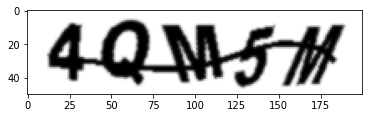

In [62]:
fake_imgs, fake_labels = next(iter(fake_dl))
ohe_label = fake_labels[0].cpu().numpy()
plt.imshow(fake_imgs[0].squeeze(), cmap='gray')
print(ohe.decode(ohe_label))

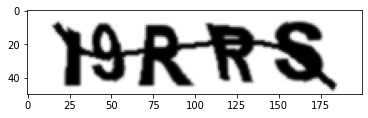

torch.Size([128, 180]) torch.Size([128, 180])
tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       dtype=torch.float64) tensor([-3.5886, -2.5077, -3.0938, -4.2892, -3.0774, -2.3776, -3.1648, -4.2810,
        -2.9075, -2.8218, -3.5501, -2.8058, -

In [66]:
fake_imgs, fake_labels = next(iter(fake_dl))
fake_imgs = fake_imgs.to(device)
preds = solver(fake_imgs)
for i in range(BATCH_SIZE):
    imarr = fake_imgs[i].cpu().numpy()
    plt.imshow(imarr.squeeze(), cmap='gray')
    plt.show()
    print(fake_labels.shape, preds.shape)
    print(fake_labels[0], preds[0])
    fake_label = ohe.decode(fake_labels[i].detach().cpu().numpy())
    pred_label = preds[i].detach().cpu().numpy()
    pred_label = [CHSET[np.argmax(pred_label[k*CHSET_LEN:(k+1)*CHSET_LEN])] for k in range(CAP_LEN)]
    print(fake_label, pred_label)
    break



In [37]:
ohe_label = fake_ds[0][1]
print(ohe_label.shape)

(180,)


In [50]:
from string import ascii_uppercase, digits
CHSET = ascii_uppercase + digits